In [158]:
from typing import List, Tuple

import numpy as np
from scipy.optimize import minimize, OptimizeResult
from matplotlib import pyplot as plt

from src.genetic import fitness
from src.simulation import Simulation
from src.pid import PIDController
from src.visualization import VisualizationFactory, VisualizationType

In [71]:
def cost_function(params: Tuple[float, float, float], mass: float, delta_t: float, setpoints: List[float], external_force: List[float], weight_factor: float) -> float:
    p, i, d = params
    pid_controller = PIDController(p, i, d, setpoint=setpoints[0])
    simulation = Simulation(mass=mass, delta_t=delta_t)
    
    positions = []
    position = 0
    for idx, setpoint in enumerate(setpoints):
        pid_controller.setpoint = setpoint
        new_angle = pid_controller.next(position)
        _, _, position = simulation.next(new_angle, external_force[idx])
        positions.append(position)
        
    error = fitness(positions, setpoints, weight_factor)
    return error

In [109]:
def callback(intermediate_result: OptimizeResult):
    print(intermediate_result)

In [110]:
fps = 30
setpoints = [-10] * fps * 10 + [5] * fps * 10 + [0] * fps * 40 + [8] * fps * 10 + [0] * fps * 10
external_force = [0] * fps * 30 + [1] * fps * 50
mass = 0.2
delta_t = 1 / fps
weight_factor = 0.4

In [154]:
initial_guess = (-5, -0.013, -170)

options = {
    'xtol': 1e-10,
    'ftol': 1e-10,
    'maxiter': 1000,
    'maxfev': 10000
}

result = minimize(
    fun=cost_function, 
    x0=initial_guess, 
    args=(
        mass,
        delta_t,
        setpoints,
        external_force,
        weight_factor
    ),
    method='Powell',
    options=options,
    callback=callback
)

result

 fun: 744.3819185746959
   x: [-6.934e+00 -1.440e-02 -1.700e+02]
 fun: 744.3819185745775
   x: [-6.934e+00 -1.440e-02 -1.700e+02]


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 744.3819185745775
       x: [-6.934e+00 -1.440e-02 -1.700e+02]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 349

In [155]:
result.x

array([-6.93354678e+00, -1.43950633e-02, -1.69977054e+02])

In [143]:
visualization = VisualizationFactory.create_visualization(VisualizationType.PID, kp=result.x[0], ki=result.x[1], kd=result.x[2])
visualization.run()

In [162]:
# Define ranges for each parameter
p_values = np.linspace(-10, 10, 1001)
i_values = np.linspace(-10, 10, 1001)
d_values = np.linspace(-300, 0, 1001)

# Sample the cost function
cost_p = [cost_function((p, initial_guess[1], initial_guess[2]), mass, delta_t, setpoints, external_force, weight_factor) for p in p_values]
cost_i = [cost_function((initial_guess[0], i, initial_guess[2]), mass, delta_t, setpoints, external_force, weight_factor) for i in i_values]
cost_d = [cost_function((initial_guess[0], initial_guess[1], d), mass, delta_t, setpoints, external_force, weight_factor) for d in d_values]

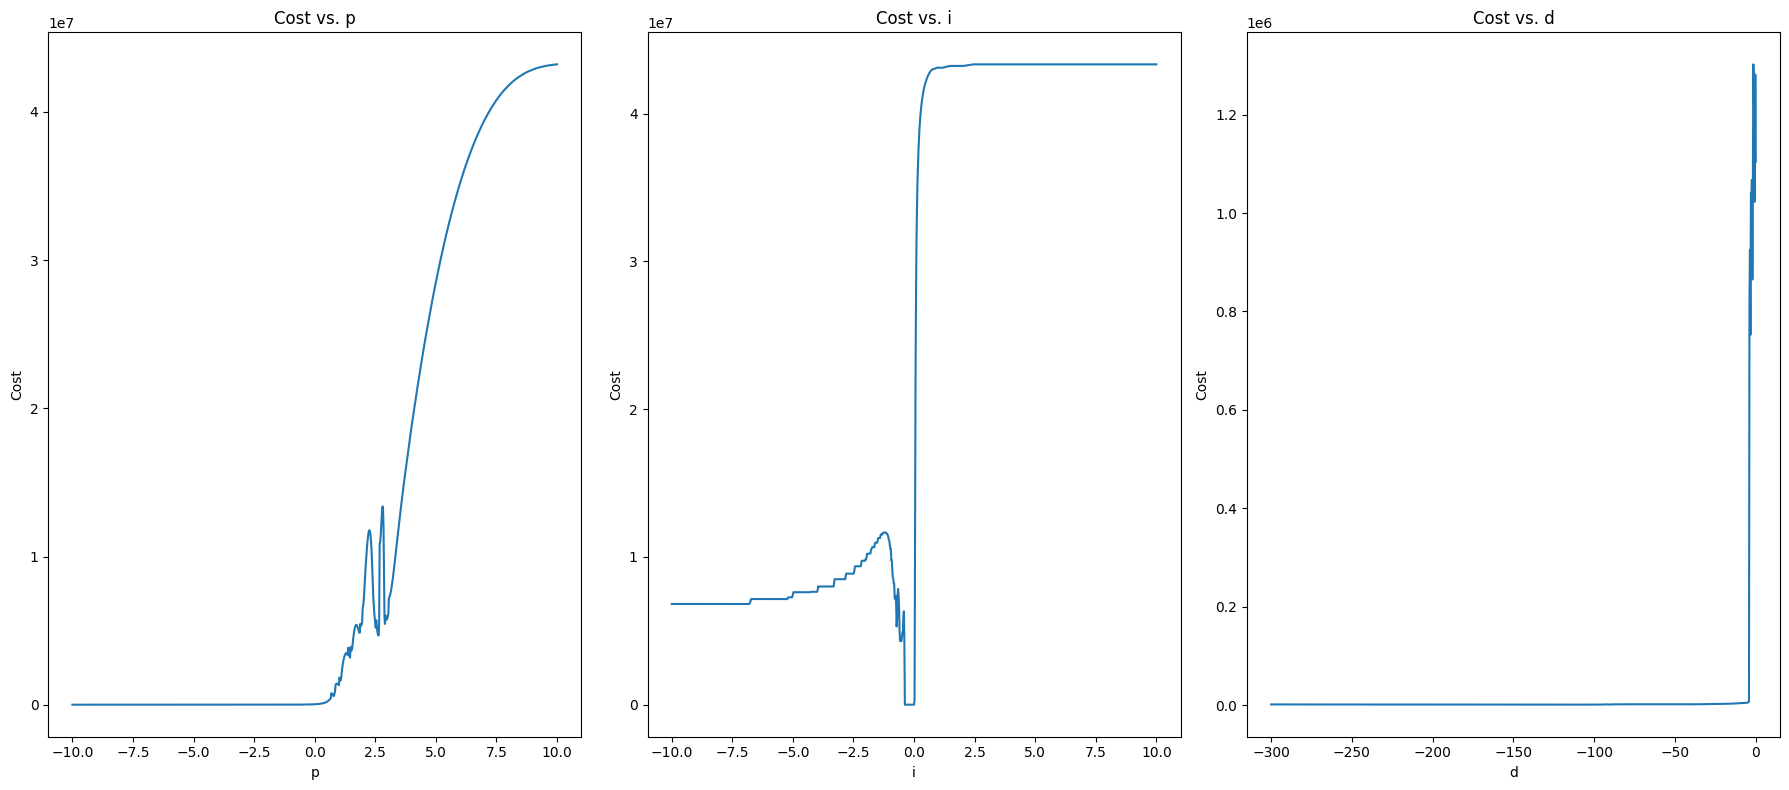

In [163]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 3, 1)
plt.plot(p_values, cost_p)
plt.xlabel('p')
plt.ylabel('Cost')
plt.title('Cost vs. p')

# Plot cost vs. i
plt.subplot(1, 3, 2)
plt.plot(i_values, cost_i)
plt.xlabel('i')
plt.ylabel('Cost')
plt.title('Cost vs. i')

# Plot cost vs. d
plt.subplot(1, 3, 3)
plt.plot(d_values, cost_d)
plt.xlabel('d')
plt.ylabel('Cost')
plt.title('Cost vs. d')

plt.tight_layout()
plt.show()